# (g) Frozen large weights
### Freezing the SNN after training on images of digits, and then training the SNN on images of letters

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import time
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

## Model

In [2]:
# learning rule

class STDP(nn.Module):

    def __init__(self, conv_layer, learning_rate, use_stabilizer = True, lower_bound = 0, upper_bound = 1):
        super(STDP, self).__init__()
        self.conv_layer = conv_layer
        if isinstance(learning_rate, list):
            self.learning_rate = learning_rate
        else:
            self.learning_rate = [learning_rate] * conv_layer.out_channels
        for i in range(conv_layer.out_channels):
            self.learning_rate[i] = (Parameter(torch.tensor([self.learning_rate[i][0]])),
                            Parameter(torch.tensor([self.learning_rate[i][1]])))
            self.register_parameter('ltp_' + str(i), self.learning_rate[i][0])
            self.register_parameter('ltd_' + str(i), self.learning_rate[i][1])
            self.learning_rate[i][0].requires_grad_(False)
            self.learning_rate[i][1].requires_grad_(False)
        self.use_stabilizer = use_stabilizer
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def get_pre_post_ordering(self, input_spikes, output_spikes, winners):

        # accumulating input and output spikes to get latencies
        input_latencies = torch.sum(input_spikes, dim=0)
        output_latencies = torch.sum(output_spikes, dim=0)
        result = []
        for winner in winners:
            # generating repeated output tensor with the same size of the receptive field
            out_tensor = torch.ones(*self.conv_layer.kernel_size, device=output_latencies.device) * output_latencies[winner]
            # slicing input tensor with the same size of the receptive field centered around winner
            # since there is no padding, there is no need to shift it to the center
            in_tensor = input_latencies[:,winner[-2]:winner[-2]+self.conv_layer.kernel_size[-2],winner[-1]:winner[-1]+self.conv_layer.kernel_size[-1]]
            result.append(torch.ge(in_tensor,out_tensor))
        return result

    # simple STDP rule
    # gets prepost pairings, winners, weights, and learning rates (all shoud be tensors)
    def forward(self, input_spikes, potentials, output_spikes, winners=None, freeze_tensor=None, kwta = 1, inhibition_radius = 0):
        if winners is None:
            winners = sf.get_k_winners(potentials, kwta, inhibition_radius, output_spikes)
        pairings = self.get_pre_post_ordering(input_spikes, output_spikes, winners)

        lr = torch.zeros_like(self.conv_layer.weight)
        for i in range(len(winners)):
            f = winners[i][0]
            lr[f] = torch.where(pairings[i], *(self.learning_rate[f]))

        # additional script for weights freezing    
        if freeze_tensor is None:
            self.conv_layer.weight += lr * ((self.conv_layer.weight-self.lower_bound) * \
                                (self.upper_bound-self.conv_layer.weight) if self.use_stabilizer else 1)
        else:
            ones_like_freeze_tensor = torch.full_like(freeze_tensor, 1)
            zero_like_freeze_tensor = torch.zeros_like(freeze_tensor)

            # condition 'freeze_tensor > 0.01' is stronger version of 'freeze_tensor > 0' for insure
            anti_freeze_tensor_byte = torch.where(freeze_tensor > 0.01, zero_like_freeze_tensor, ones_like_freeze_tensor)
            self.conv_layer.weight += lr * ((self.conv_layer.weight-self.lower_bound) * \
                                (self.upper_bound-self.conv_layer.weight) if self.use_stabilizer else 1) * \
                                anti_freeze_tensor_byte

        self.conv_layer.weight.clamp_(self.lower_bound, self.upper_bound)

    def update_learning_rate(self, feature, ap, an):
        r"""Updates learning rate for a specific feature map.

        Args:
            feature (int): The target feature.
            ap (float): LTP rate.
            an (float): LTD rate.
        """
        self.learning_rate[feature][0][0] = ap
        self.learning_rate[feature][1][0] = an

    def update_all_learning_rate(self, ap, an):
        r"""Updates learning rates of all the feature maps to a same value.

        Args:
            ap (float): LTP rate.
            an (float): LTD rate.
        """
        for feature in range(self.conv_layer.out_channels):
            self.learning_rate[feature][0][0] = ap
            self.learning_rate[feature][1][0] = an

In [3]:
# model

class MozafariMNIST2018(nn.Module):
    
    def __init__(self, dropout=0.5, dropout_procedure = False):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)
        self.number_of_features = 200
        
        self.dropout = dropout

        self.stdp1 = STDP(self.conv1, (0.004, -0.003))                          
        self.stdp2 = STDP(self.conv2, (0.004, -0.003))                          
        self.stdp3 = STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)         
        self.anti_stdp3 = STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8)   
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, \
                    "output_spikes":None, "winners":None, \
                    "freeze_tensor":None}                           # freeze_tensor was added to original ver.                         
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0
        
        self.dropout_procedure = dropout_procedure
        
    def forward(self, input, max_layer, freeze_tensor=None):    # freeze_tensor was added to original ver.            
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)           
            
            if self.dropout_procedure:
                dropout = torch.ones(self.number_of_features) * self.dropout
                to_be_dropped = torch.bernoulli(dropout).nonzero()   
                sf.feature_inhibition_(pot, to_be_dropped)
            
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            self.ctx["freeze_tensor"] = freeze_tensor

            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"], self.ctx["freeze_tensor"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"], self.ctx["freeze_tensor"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
               
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)  
 
    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"], self.ctx["freeze_tensor"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"], self.ctx["freeze_tensor"])
        

In [4]:
# train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target, freeze_tensor=None):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3, freeze_tensor)    # freeze_tensor was added
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward() 
            else:
                perf[1]+=1
                network.punish()  
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [5]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        #if self.cnt % 10000 == 0:
        #    print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [6]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [7]:
def draw_3(text, freeze_list):     
    
    dict_layer = {}
    
    for index, param in enumerate(mozafari.conv3.named_parameters()):
        dict_layer.update([(param[0], param[1].detach().clone())])
    
    plt.subplots(figsize=(15, 3))
    conv_list = dict_layer['weight'].flatten().cpu().detach().clone().numpy()
    plt.title(f'epoch #{text}', fontsize=17)
    plt.xlabel('weights', loc='right', fontsize=15)
    plt.ylabel('quantity of weights',  loc='top', fontsize=15)
    plt.xlim(left=0.2, right=1.0);
    plt.ylim(bottom=1, top=1e5);
    plt.grid()
    plt.hist(conv_list, log=True, bins=500, color='c')[0].sum()
    plt.hist(freeze_list, log=True, bins=500, color='r')
    plt.show()
    
    return dict_layer

In [8]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [9]:
# train of 3-rd layer

def third_layer(file_name_net, file_name_csv, adaptive_int, previous_epochs, epochs, 
                train_loader, test_loader, test_previous_loader,
                model, apr, anr, app, anp, parametr_set, model_number=0, high_pc=90, 
                steps=None, percent=20, it_continues=False, freeze_procedure=False):  
    
    '''
    file_name_net - name of file for saving state_dict of model
    file_name_csv - name of file for saving parameters of model in each epoch
    adaptive_int - learning rate parameter
    previous_epochs - if before model had training in current period
    it_continues - is it continue of 3-rd layer training or not (False or True)
    percent - percent of moving weights (calculated from the number of high range weights)
    '''

    adaptive_min=0 

    if not it_continues:

        previous_epochs = 0
        counter = 0

        apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
        anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
        app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
        anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp
        
        best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test_previous = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch

    else:
      
        if len(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch']) == 1:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].item())
        else:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch']) == 1:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].item())
        else:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch']) == 1:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].item())
        else:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].tolist()[-1])
        
        max_index = int(parametr_set.index.max())
        counter = (max_index + 1)

        param_best_train = parametr_set['train'].iloc[best_train_index]
        param_best_test = parametr_set['test'].iloc[optim_index]
        param_best_test_previous = parametr_set['test_previous'].iloc[best_test_previous_index]

        apr_adapt = parametr_set['apr_adapt'].iloc[optim_index]
        anr_adapt = parametr_set['anr_adapt'].iloc[optim_index]
        app_adapt = parametr_set['app_adapt'].iloc[optim_index]
        anp_adapt = parametr_set['anp_adapt'].iloc[optim_index]
        
        for i in range(len(model.stdp3.learning_rate)):
            model.stdp3.learning_rate[i][0].fill_(parametr_set['stdp3.learning_rate[0]'].iloc[optim_index])
            model.stdp3.learning_rate[i][1].fill_(parametr_set['stdp3.learning_rate[1]'].iloc[optim_index])
            model.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[0]'].iloc[optim_index])
            model.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[1]'].iloc[optim_index])

        best_train = np.array([param_best_train,1-param_best_train,0.0,best_train_index]) # correct, wrong, silence, epoch
        best_test = np.array([param_best_test,1-param_best_test,0.0,optim_index]) # correct, wrong, silence, epoch
        best_test_previous = np.array([param_best_test_previous,1-param_best_test_previous,0.0,best_test_previous_index]) # correct, wrong, silence, epoch
    
    # list of 3-rd layer weights

    dim_0, dim_1, dim_2, dim_3 = tuple(model.conv3.weight.size())
    total_size = dim_0 * dim_1 * dim_2 * dim_3
  
    # indexes of weights
    indexes_i = []    
    indexes_j = []        
    indexes_k = []        
    indexes_m = []    
    
    # values of weights
    item_values = []  
    
    for i in range(dim_0):
        for j in range(dim_1):
            for k in range(dim_2):
                for m in range(dim_3):
                    indexes_i.append(i)
                    indexes_j.append(j)
                    indexes_k.append(k)
                    indexes_m.append(m)
                    item_values.append(model.conv3.weight[i][j][k][m].item())

    indexes_dim_0 = pd.Series(indexes_i, name='dim_0') 
    indexes_dim_1 = pd.Series(indexes_j, name='dim_1')
    indexes_dim_2 = pd.Series(indexes_k, name='dim_2')
    indexes_dim_3 = pd.Series(indexes_m, name='dim_3')
    item_values = pd.Series(item_values, name='value_0')
            
    conv3_data = pd.concat([item_values, indexes_dim_0, indexes_dim_1, indexes_dim_2, indexes_dim_3], axis=1)
    
    high_percent = high_pc #percent of high range weights
    percentile_value = np.percentile(item_values, high_percent)
    
    conv3_data['low_range_0'] = 0
    conv3_data.loc[conv3_data['value_0'] < percentile_value,'low_range_0'] = 1
    
    # indexes of freeze weights of third layer before training on the next set                   
    conv3_data['freeze_weights'] = 0
    conv3_data.loc[conv3_data['value_0'] > percentile_value,'freeze_weights'] = 1      
    
    if freeze_procedure:
        
        print(f"During training {conv3_data['freeze_weights'].sum()} weights "
              f"({conv3_data['freeze_weights'].sum()/total_size*100 :.1f}%) will be freezed")
        
        weights_threshold = nn.Threshold(percentile_value, 0)
        freeze_tensor = weights_threshold(model.conv3.weight)                     
        freeze_list = conv3_data.loc[conv3_data['freeze_weights'] == 1, 'value_0'].to_numpy()
        
        torch.save(freeze_tensor, f"freeze_tensor_3rd_layer_model_{model_number}.net") # !!!! SAVING

    try:
        high_range_counter = conv3_data['low_range_0'].value_counts()[0] 
    except:
        high_range_counter = 1
 
    moving_quantity = int((percent/100)*high_range_counter)      #quantity of moving items in each epoch
    #quantity of moving items in each epoch is calculated without taking in account freezed weights
    
    if steps is None:
        steps = int(total_size*high_percent/(100*moving_quantity))   #steps of weights moving 
        print(f'Weight moving will be during {steps} epochs')
    elif steps == 0:
        print(f'Training will be performed without weight moving.')
    else:
        print(f'Weight moving will be during {steps} epochs')
    
    for epoch in range(epochs):
        
        seconds_epoch_0 = time.time() 
        
        print("Epoch #: ", epoch + previous_epochs)
        
        perf_train = np.array([0.0,0.0,0.0]) 
        
        for data,targets in train_loader:
                
            if epoch < steps: 
                
                print(f'Values of high range weights in epoch#{epoch} [{percentile_value :.3f}:0.800] (top {100-high_percent}%)')
                low_range_indexes = list(conv3_data.index[(conv3_data['low_range_'+str(epoch)] == 1)&(conv3_data['freeze_weights'] == 0)])
                moving_items = random.sample(low_range_indexes, np.minimum(moving_quantity, len(low_range_indexes)))
                moving_indexes = conv3_data.loc[conv3_data.index.isin(moving_items)]

                print(f'Quantity of moving points in epoch#{epoch + previous_epochs} = {len(moving_indexes.index)} items' 
                      f' ({len(moving_indexes.index)/(total_size-high_range_counter)*100 :.1f}% of moving points)')

                for q in range(len(moving_indexes.index)):
                    model.conv3.weight \
                    [moving_indexes['dim_0'].iloc[q]][moving_indexes['dim_1'].iloc[q]][moving_indexes['dim_2'].iloc[q]][moving_indexes['dim_3'].iloc[q]]. \
                    fill_(np.random.normal(loc=0.8, scale=0.05))  
                
            perf_train_batch = train_rl(model, data, targets, freeze_tensor)        
            
            if epoch < steps:  
            
                # new values of weights (after learning)
                item_values = []       
                for i in range(dim_0):
                    for j in range(dim_1):
                        for k in range(dim_2):
                            for m in range(dim_3):
                                item_values.append(model.conv3.weight[i][j][k][m].item())
            
                item_values = pd.Series(item_values, name='value_'+str(epoch+1))
                percentile_value = np.percentile(item_values, high_percent) #new cutting off high range weights
                conv3_data = pd.concat([conv3_data, item_values], axis=1)
                
                conv3_data['low_range_'+str(epoch+1)] = 0
                conv3_data.loc[conv3_data['value_'+str(epoch+1)] < percentile_value,'low_range_'+str(epoch+1)] = 1
       
            #update adaptive learning rates
            apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
            anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
            parametr_set.loc[counter, 'epoch'] = epoch + previous_epochs
            parametr_set.loc[counter, 'apr_adapt'] = apr_adapt
            parametr_set.loc[counter, 'anr_adapt'] = anr_adapt
            parametr_set.loc[counter, 'app_adapt'] = app_adapt
            parametr_set.loc[counter, 'anp_adapt'] = anp_adapt
            parametr_set.loc[counter, 'stdp3.learning_rate[0]'] = model.stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'stdp3.learning_rate[1]'] = model.stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[0]'] = model.anti_stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[1]'] = model.anti_stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'train'] = perf_train_batch[0]

            model.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
            perf_train += perf_train_batch
            
        perf_train /= len(train_loader)        
                   
        if epoch%(epochs-1) == 0:
            torch.save(model.state_dict(), f"freeze_model_{model_number}_epoch_{epoch}.net") # !!!!! SAVING
            pic = draw_3(f'{epoch + previous_epochs} after train RL', freeze_list)

        if best_train[0] <= perf_train[0]:
            best_train = np.append(perf_train, epoch + previous_epochs)
        print(f"Current Train: {perf_train[0]*100 :.2f}%")

        for data,targets in test_loader:
            perf_test = test(model, data, targets)
            parametr_set.loc[counter, 'test'] = perf_test[0]
            if best_test[0] <= perf_test[0]:
                best_test = np.append(perf_test, epoch + previous_epochs)
                torch.save(model.state_dict(), file_name_net)
            print(f"Current Test: {perf_test[0]*100 :.2f}%")

        if isinstance(test_previous_loader, DataLoader):
            for data,targets in test_previous_loader:
                perf_test_previous = test(model, data, targets)
                parametr_set.loc[counter, 'test_previous'] = perf_test_previous[0]
                if best_test_previous[0] <= perf_test_previous[0]:
                    best_test_previous = np.append(perf_test_previous, epoch + previous_epochs)
                print(f"Current Test Previous: {perf_test_previous[0]*100 :.2f}%")
                
        else:
            parametr_set.loc[counter, 'test_previous'] = 0
            
        counter += 1
                                                 
        seconds_epoch_1 = time.time()  
        print(f'Operational time of epoch #{epoch + previous_epochs}: '
                  f'{int((seconds_epoch_1 - seconds_epoch_0)//60)} min {int((seconds_epoch_1 - seconds_epoch_0)%60)} sec') 
    
    parametr_set.to_csv(file_name_csv)
    
    print('=='*10, 'SUMMARY', '=='*10)
    print(f"        Best Train: {best_train[0]*100 :.2f}% on {best_train[3] :.0f} epoch")
    print(f"         Best Test: {best_test[0]*100 :.2f}% on {best_test[3] :.0f} epoch")
    print(f"Best Test Previous: {best_test_previous[0]*100 :.2f}% on {best_test_previous[3] :.0f} epoch")
    
    return parametr_set, counter, (previous_epochs+epochs), apr, anr, app, anp, conv3_data

In [10]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

# Sets

### Set of 10 capital letters
24000 train images + 4000 test images

In [12]:
# set of 10 capital letters from EMNIST

path = f'./data/EMNIST_own/capital_letters/'

test_letter_labels = torch.load(f'{path}Mozafari_capital_letters_test_labels.pt', map_location=torch.device('cpu'))
test_letters = torch.load(f'{path}Mozafari_capital_letters_test_images.pt', map_location=torch.device('cpu'))

train_letter_labels = torch.load(f'{path}Mozafari_capital_letters_train_labels.pt', map_location=torch.device('cpu'))
train_letters = torch.load(f'{path}Mozafari_capital_letters_train_images.pt', map_location=torch.device('cpu'))

# Element permutation

train_order_l = torch.randperm(train_letter_labels.shape[0])
test_order_l = torch.randperm(test_letter_labels.shape[0])

train_letter_labels = train_letter_labels[train_order_l].view(train_letter_labels.size())
train_letters = train_letters[train_order_l].view(train_letters.size())

test_letter_labels = test_letter_labels[test_order_l].view(test_letter_labels.size())
test_letters = test_letters[test_order_l].view(test_letters.size())

# Loaders

train_letter_set = CustomTensorDataset(tensors=(train_letters, train_letter_labels), transform=s1c1_PIL)
test_letter_set = CustomTensorDataset(tensors=(test_letters, test_letter_labels), transform=s1c1_PIL)

train_letter_loader = DataLoader(train_letter_set, batch_size=len(train_letter_set))
test_letter_loader = DataLoader(test_letter_set, batch_size=len(test_letter_set))

### Set of 10 digits
Reduction the MNIST set of 60000 train + 10000 test images to the set of 24000 train + 4000 test images

In [13]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# the set of 10 digit images, the same size as the set of letters (2400 trains + 400 tests per class)

# the MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'

for i in classes: 
    globals()[f'train_digit_{i}_images'] = torch.load(f'{path}train_images_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'train_digit_{i}_labels'] = torch.load(f'{path}train_labels_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_digit_{i}_images'] = torch.load(f'{path}test_images_{i}.pt', map_location=torch.device('cpu'))[0:400]
    globals()[f'test_digit_{i}_labels'] = torch.load(f'{path}test_labels_{i}.pt', map_location=torch.device('cpu'))[0:400]

train_MNIST_labels = globals()[f'train_digit_0_labels']
train_MNIST_images = globals()[f'train_digit_0_images']
test_MNIST_labels = globals()[f'test_digit_0_labels']
test_MNIST_images = globals()[f'test_digit_0_images']                                 

for i in range(1, 10):
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{i}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{i}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{i}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{i}_images']), 0)
    
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

# Loaders

train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), transform=s1c1_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), transform=s1c1_PIL)

train_digit_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set))
test_digit_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set))

train_MNIST_labels.size(), test_MNIST_labels.size()

(torch.Size([24000]), torch.Size([4000]))

## Model activation

In [14]:
mozafari = MozafariMNIST2018()

In [15]:
use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

CUDA is available


In [16]:
if use_cuda:
    mozafari.cuda()   
#mozafari.to(device)
mozafari.eval()

MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

## Continuous learning  
Training on letters (3rd layer is trained with freezing of the 'upper' weights)

### Saving all values of parameters before training on digits

In [17]:
learning_rate_from_scratch = {'stdp1': [mozafari.stdp1.learning_rate[0][0].item(), 
                                        mozafari.stdp1.learning_rate[0][1].item()],
                              'stdp2': [mozafari.stdp2.learning_rate[0][0].item(), 
                                        mozafari.stdp2.learning_rate[0][1].item()],
                              'stdp3': [mozafari.stdp3.learning_rate[0][0].item(), 
                                        mozafari.stdp3.learning_rate[0][1].item()],
                              'anti_stdp3': [mozafari.anti_stdp3.learning_rate[0][0].item(), 
                                             mozafari.anti_stdp3.learning_rate[0][1].item()]
                             }

### Installation of SNN trained on 24,000 images of digits

In [18]:
# file "saved_24000_digits.net" is the result of the file "Initial_learning_of_SNN_on_digits.ipynb"
mozafari.load_state_dict(torch.load("saved_24000_digits.net"))

<All keys matched successfully>

### Training the first layer

In [19]:
print("Training the first layer")

for epoch in range(2):
    print("Epoch", epoch)
    iter = 0
    for data, targets in train_letter_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 1)
        print("Done!")
        iter+=1

Training the first layer
Epoch 0
Iteration 0
Done!
Epoch 1
Iteration 0
Done!


### Training the second layer

In [20]:
print("Training the second layer")

for epoch in range(4):
    print("Epoch", epoch)
    iter = 0
    for data,targets in train_letter_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 2)
        print("Done!")
        iter+=1

Training the second layer
Epoch 0
Iteration 0
Done!
Epoch 1
Iteration 0
Done!
Epoch 2
Iteration 0
Done!
Epoch 3
Iteration 0
Done!


### Training the third layer 
Training on letters with freezing of the 'upper' weights

In [21]:
# Moving learning_rates 

for i in range(len(mozafari.stdp3.learning_rate)):
                    mozafari.stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['stdp3'][0])
                    mozafari.stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['stdp3'][1])
                    mozafari.anti_stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['anti_stdp3'][0])
                    mozafari.anti_stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['anti_stdp3'][1])

In [22]:
# initial adaptive learning rates

apr = mozafari.stdp3.learning_rate[0][0].item()
anr = mozafari.stdp3.learning_rate[0][1].item()
app = mozafari.anti_stdp3.learning_rate[0][1].item()
anp = mozafari.anti_stdp3.learning_rate[0][0].item()
               
parametr_set = pd.DataFrame(columns=['epoch', 'train', 'test', 'test_previous',   
                                 'apr_adapt', 'anr_adapt', 'app_adapt', 'anp_adapt', 
                                 'stdp3.learning_rate[0]', 'stdp3.learning_rate[1]',
                                 'anti_stdp3.learning_rate[0]', 'anti_stdp3.learning_rate[1]'])

During training 125000 weights (10.0%) will be freezed
Training will be performed without weight moving.
Epoch #:  0


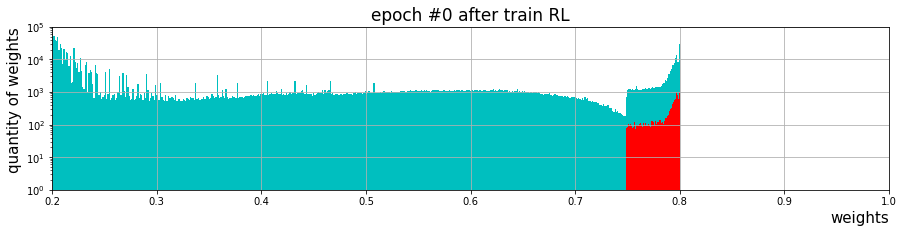

Current Train: 49.23%
Current Test: 62.30%
Current Test Previous: 81.65%
Operational time of epoch #0: 2 min 9 sec
Epoch #:  1
Current Train: 62.71%
Current Test: 62.55%
Current Test Previous: 79.40%
Operational time of epoch #1: 2 min 11 sec
Epoch #:  2
Current Train: 64.61%
Current Test: 63.90%
Current Test Previous: 83.33%
Operational time of epoch #2: 2 min 9 sec
Epoch #:  3
Current Train: 65.54%
Current Test: 64.45%
Current Test Previous: 84.15%
Operational time of epoch #3: 2 min 7 sec
Epoch #:  4
Current Train: 65.97%
Current Test: 64.83%
Current Test Previous: 84.92%
Operational time of epoch #4: 2 min 11 sec
Epoch #:  5
Current Train: 66.64%
Current Test: 65.65%
Current Test Previous: 84.85%
Operational time of epoch #5: 2 min 10 sec
Epoch #:  6
Current Train: 67.50%
Current Test: 66.65%
Current Test Previous: 84.58%
Operational time of epoch #6: 2 min 9 sec
Epoch #:  7
Current Train: 68.40%
Current Test: 67.12%
Current Test Previous: 84.80%
Operational time of epoch #7: 2 min

Current Train: 71.33%
Current Test: 69.88%
Current Test Previous: 82.38%
Operational time of epoch #64: 2 min 10 sec
Epoch #:  65
Current Train: 71.24%
Current Test: 69.70%
Current Test Previous: 82.45%
Operational time of epoch #65: 2 min 8 sec
Epoch #:  66
Current Train: 71.05%
Current Test: 69.60%
Current Test Previous: 82.25%
Operational time of epoch #66: 2 min 5 sec
Epoch #:  67
Current Train: 71.03%
Current Test: 69.55%
Current Test Previous: 82.25%
Operational time of epoch #67: 2 min 5 sec
Epoch #:  68
Current Train: 70.89%
Current Test: 69.67%
Current Test Previous: 82.15%
Operational time of epoch #68: 2 min 5 sec
Epoch #:  69
Current Train: 70.86%
Current Test: 69.53%
Current Test Previous: 82.00%
Operational time of epoch #69: 2 min 6 sec
Epoch #:  70
Current Train: 70.80%
Current Test: 69.47%
Current Test Previous: 81.90%
Operational time of epoch #70: 2 min 6 sec
Epoch #:  71
Current Train: 70.75%
Current Test: 69.45%
Current Test Previous: 81.83%
Operational time of epo

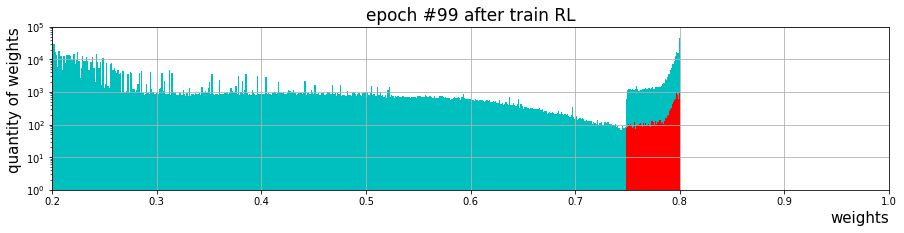

Current Train: 69.92%
Current Test: 68.35%
Current Test Previous: 80.55%
Operational time of epoch #99: 2 min 10 sec
==================== SUMMARY ====================
        Best Train: 73.14% on 53 epoch
         Best Test: 72.02% on 53 epoch
Best Test Previous: 86.05% on 14 epoch


In [23]:
# train the 3-rd layer

first_test = third_layer(file_name_net="saved_freeze_digit_weights_and_train_letter_total.net",
                        file_name_csv='parameter_set_freeze_digit_weights_and_train_letter.csv',
                        adaptive_int=0.5, previous_epochs=0, epochs=100, 
                        train_loader=train_letter_loader, 
                        test_loader=test_letter_loader, 
                        test_previous_loader=test_digit_loader,
                        model=mozafari, apr=apr, anr=anr, app=app, anp=anp, parametr_set=parametr_set, 
                        model_number=0, 
                        high_pc=90, 
                        steps=0, percent=0, it_continues=False, freeze_procedure=True)

parametr_set = first_test[0] 
counter = first_test[1] 
previous_epochs = first_test[2]
apr = first_test[3] 
anr = first_test[4] 
app = first_test[5] 
anp = first_test[6]
conv3_data_train = first_test[7]

## Results chart

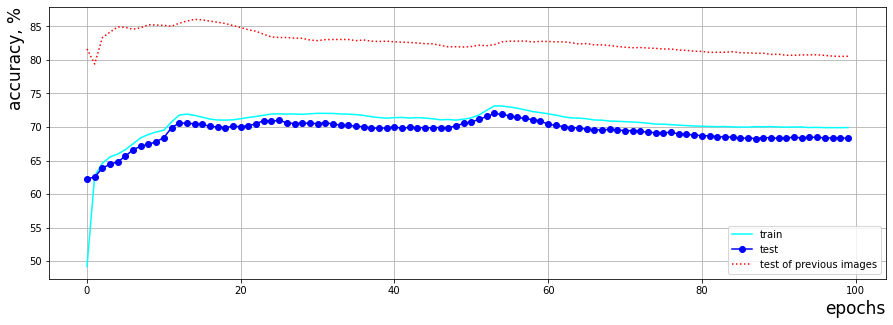

In [24]:
curve_graph(parametr_set)